In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('FrenchRetail.csv')
y = df['French Retail Sales Index']

Specifications:
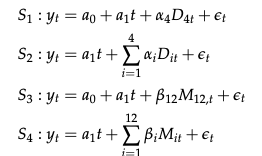

S1: Intercept, Trend, fourth quarter

S2: Trend, all quarters

S3: Intercept, Trend, 12t month dummy

S4: Trend, all month dummy

For each specification, estimate the values of each parameter. Also compute MSE, AIC, BIC.

S1: Intercept, trend, fourth quarter

In [3]:
class model:
    x = df['French Real GDP']
    
    def __init__(self, data, quarters=False, month=False, last=False, MSFE = False, GDP = False, h=0):
        ''' Quarters OR month'''
        self.data = data
        self.quarters = quarters
        self.month = month
        self.last = last 
        self.MSFE = MSFE
        self.GDP = GDP
        self.h = h
        self.x = self.x.shift(periods=h)[h:]
        self.y = df['French Retail Sales Index']
        self.y = self.y[h:]
        
    def __repr__(self):
        return 'Quarters dummy: {}\nMonths dummy: {}\nOnly Last: {}\nParameters: {}\nModel Evals: {}'.format(
            self.quarters, self.month, self.last, self.parameter_estimation(), self.model_eval())
        #Print model specification, parameter estimation, model_eval

    def Specification(self):
        '''Changes the dataframe to be in quarter or month form'''
        df = pd.read_csv(self.data)
        df['DATE'] = pd.to_datetime(df['DATE'], dayfirst = True)
        if self.quarters:
            df['DATE']=df['DATE'].dt.quarter
            return df
        if self.month:
            df['DATE']=df['DATE'].dt.month
            return df
    
    def dummies(self):
        '''Makes dummies based on if quarter or month'''
        mod = self.Specification()
        X = pd.get_dummies(mod['DATE'])
        X = X.reset_index()
        X.rename(columns={'index':'t'}, inplace=True)
            #Also needs an intercept
        if self.last:
            X.insert(0,'a0',1)
            if self.GDP:
                X = X.join(self.x)
                X = X[self.h:]
                return X.iloc[:,:2].join(X.iloc[:,-2:])
            else:
                return X.iloc[:,:2].join(X.iloc[:,-1:])
        if self.GDP:
            X = X.join(self.x)
            X = X[self.h:]
        return X
    
    def parameter_estimation(self):
        '''Estimates the parameters for the model'''
        X = self.dummies()
        if self.GDP and self.last:
            #print(X)
            #print(self.y)
            a0, t, dummy, gdp = np.linalg.inv((X.T@X)) @ X.T@self.y
            return a0, t, dummy, gdp
        if self.last:
            a0, t, dummy = np.linalg.inv((X.T@X)) @ X.T@self.y
            return a0, t, dummy
        if self.GDP:
            #print(np.linalg.inv((X.T@X)) @ X.T@self.y)
            t, gdp, *dummy = np.linalg.inv((X.T@X)) @ X.T@self.y
            return np.linalg.inv((X.T@X)) @ X.T@self.y
        else:
            t, *dummy = np.linalg.inv((X.T@X)) @ X.T@self.y
            return np.append(t, dummy)
    
    def y_hat(self):
        matrix = np.array(self.parameter_estimation())
        return self.dummies()@matrix.T

    def model_eval(self):
        MSE = np.mean((self.y - self.y_hat())**2)
        T = len(self.y)
        AIC = T * MSE + (5*2)
        BIC = T * MSE + 5*np.log(T)
        return MSE, AIC, BIC
    
    def MSFE_1(self, T0, h, plot=False):
        X = self.dummies()
        T = len(self.y)
        syhat = []
        for i in range(T0, T-h):
            temp_y = self.y[:i]
            temp_X = X[:i]
            temp_X = np.array(temp_X)
            test = temp_X.T@temp_y
            y_hat2 = temp_X @ (np.linalg.inv((temp_X.T@temp_X)) @ test)
            syhat.append(y_hat2[-1])
        if plot:
            return syhat
        
        return np.mean((self.y[T0+h:]-syhat)**2)

In [4]:
first_specification = model('FrenchRetail.csv', quarters=True, last=True)
first_specification

Quarters dummy: True
Months dummy: False
Only Last: True
Parameters: (41.618862803791345, 0.20650577727291358, 10.156798308243614)
Model Evals: (58.6531961580335, 20069.393086047457, 20088.56713973277)

In [5]:
second_specification = model('FrenchRetail.csv', quarters=True, last=False)
second_specification

Quarters dummy: True
Months dummy: False
Only Last: False
Parameters: [ 0.20643543 38.99272069 42.52915929 43.43272011 51.78776006]
Model Evals: (55.880064610790924, 19120.982096890497, 19140.15615057581)

In [6]:
third_specification = model('FrenchRetail.csv', month=True, last=True)
third_specification

Quarters dummy: False
Months dummy: True
Only Last: True
Parameters: (42.21519118759896, 0.20639807776037436, 23.410957746641994)
Model Evals: (36.570723494742225, 12517.18743520184, 12536.361488887153)

In [7]:
fourth_specification = model('FrenchRetail.csv', month=True, last=False)
fourth_specification

Quarters dummy: False
Months dummy: True
Only Last: False
Parameters: [ 0.20620485 41.43654041 33.99363828 41.66489159 41.4755834  42.75920055
 43.47167741 36.36290765 51.4058865  42.64627439 46.80127285 43.02141288
 65.65957797]
Model Evals: (19.048020662812522, 6524.423066681883, 6543.597120367196)

In [8]:
def plot_graph(y_hat):
    plt.rcParams['figure.figsize'] = [15, 6]
    plt.plot(range(50, len(y_hat)+50), y_hat)
    plt.plot(y, alpha=0.4)
    return plt.show()

89.74992034457756


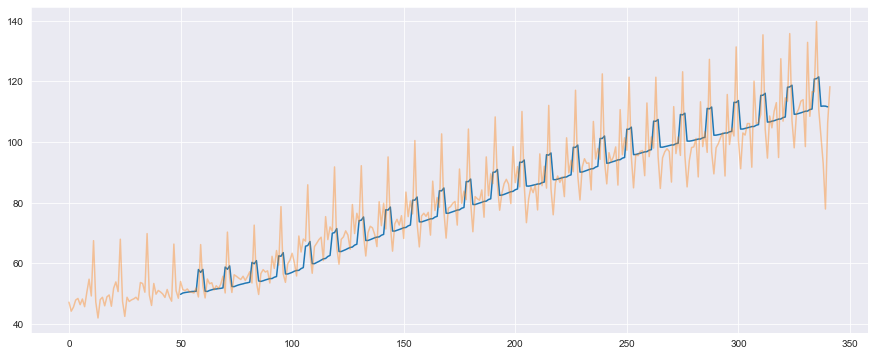

In [9]:
#MSFE at h = 1
print(first_specification.MSFE_1(T0=50, h=1))
plot_graph(first_specification.MSFE_1(T0=50, h=1, plot=True))

127.65943021557673


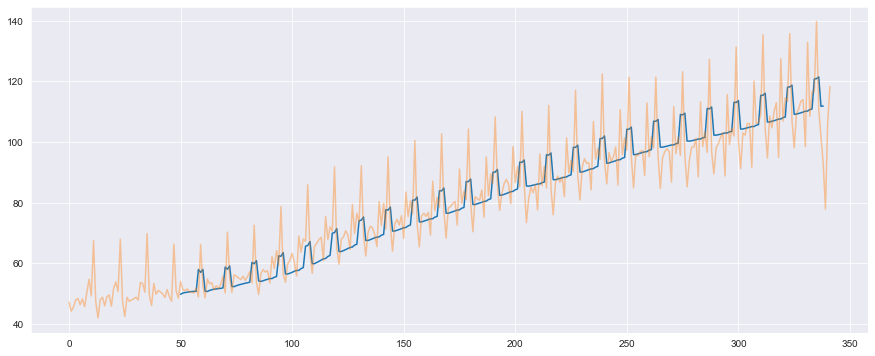

In [10]:
#MSFE at h = 3
print(first_specification.MSFE_1(T0=50, h=3))
plot_graph(first_specification.MSFE_1(T0=50, h=3, plot=True))

88.31619795120181


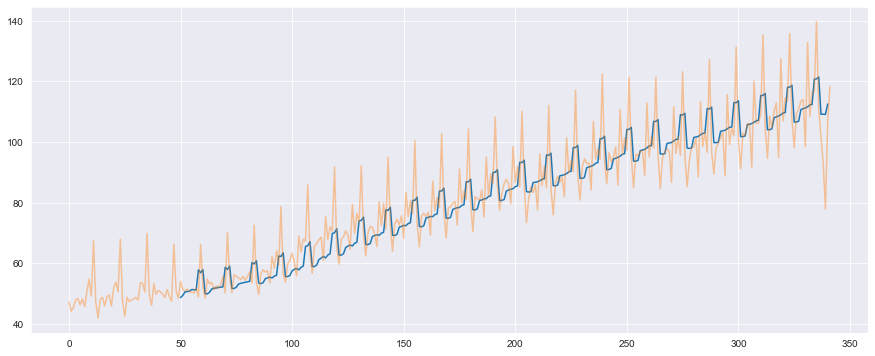

In [11]:
#MSFE at h = 1
print(second_specification.MSFE_1(T0=50, h=1))
plot_graph(second_specification.MSFE_1(T0=50, h=1, plot=True))

120.7142295221706


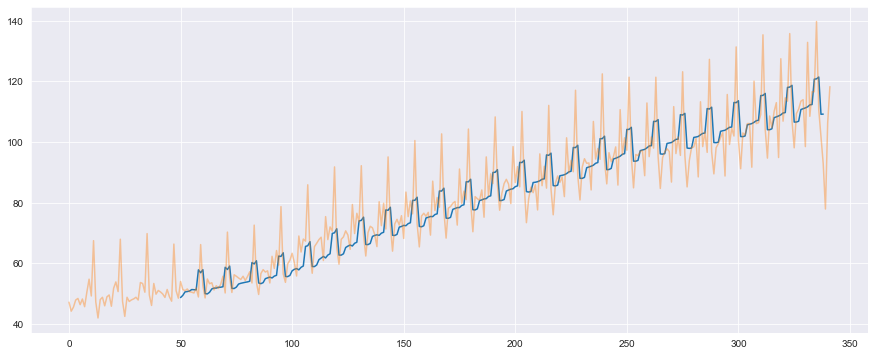

In [12]:
#MSFE at h = 3
print(second_specification.MSFE_1(T0=50, h=3))
plot_graph(second_specification.MSFE_1(T0=50, h=3, plot=True))

157.82312036075066


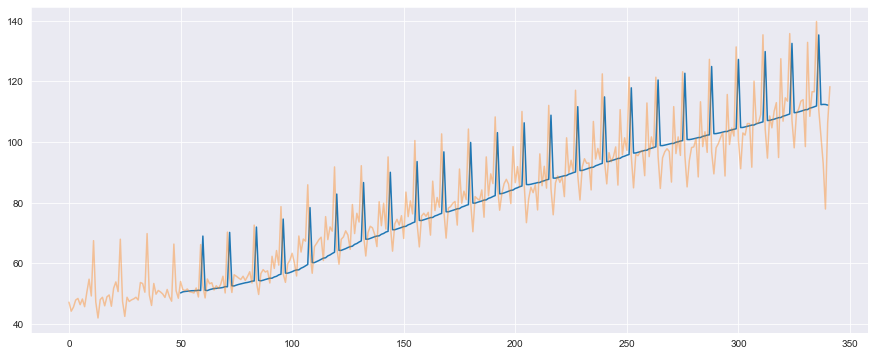

In [13]:
#MSFE at h = 1
print(third_specification.MSFE_1(T0=50, h=1))
plot_graph(third_specification.MSFE_1(T0=50, h=1, plot=True))

133.24576775040032


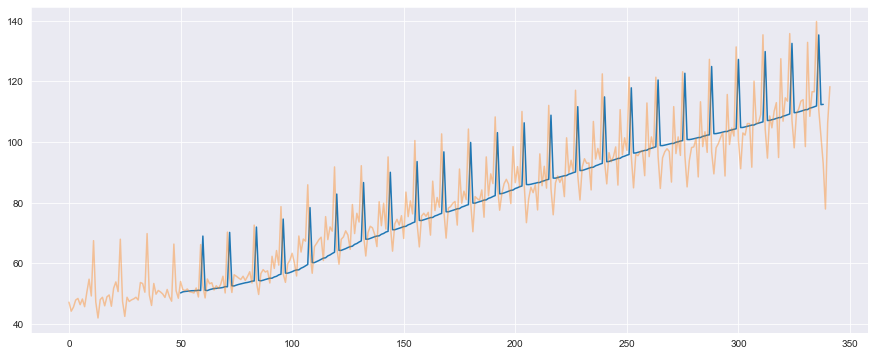

In [14]:
#MSFE at h = 3
print(third_specification.MSFE_1(T0=50, h=3))
plot_graph(third_specification.MSFE_1(T0=50, h=3, plot=True))

144.2556675914785


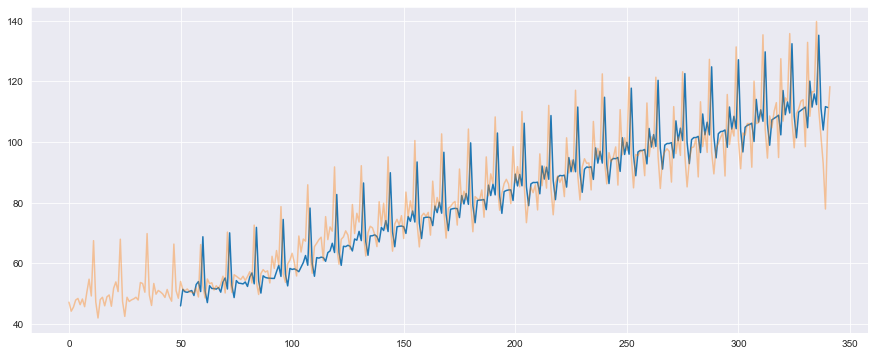

In [15]:
#MSFE at h = 1
print(fourth_specification.MSFE_1(T0=50, h=1))
plot_graph(fourth_specification.MSFE_1(T0=50, h=1, plot=True))

131.29892033447098


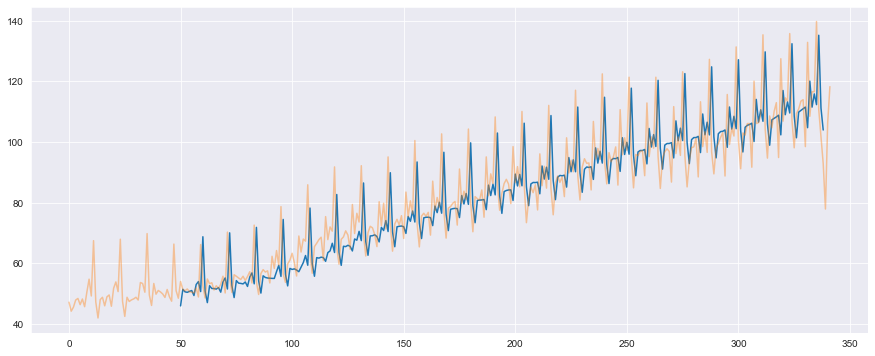

In [16]:
#MSFE at h = 3
print(fourth_specification.MSFE_1(T0=50, h=3))
plot_graph(fourth_specification.MSFE_1(T0=50, h=3, plot=True))

## Question 2

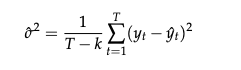

In [58]:
y = df['French Retail Sales Index']
def var(Spec):
    k = len(Spec.dummies().columns)
    T = len(Spec.Specification())
    y_hat = Spec.y_hat()
    return np.sum(((y-y_hat)**2))*(1/(T-k)), y_hat

In [59]:
print('''Variance of the first: {}\nVariance of the second: {}
Variance of the third: {}\nVariance of the fourth: {}'''.format(var(first_specification)[0],
                                                                var(second_specification)[0], 
                                                                var(third_specification)[0], 
                                                                var(fourth_specification)[0]))

Variance of the first: 59.17225099129041
Variance of the second: 56.70914568810239
Variance of the third: 36.89435821593464
Variance of the fourth: 19.800678014230645


In [60]:
def confidence_interval(spec):
    B = spec.parameter_estimation() #Paramters
    var_ = var(spec)[0]
    index = df[df['DATE']=='1/04/2020'].index
    X = np.array(spec.dummies().iloc[index]) #XT
    return (X@B - var_, X@B + var_)

In [61]:
print('First specification: {}\nSecond specification: {}\nThird specification: {}\nFourth specification: {}'.format(
confidence_interval(first_specification),confidence_interval(second_specification),confidence_interval(third_specification),
confidence_interval(fourth_specification)))

First specification: (array([52.45207031]), array([170.79657229]))
Second specification: (array([55.80162591]), array([169.21991728]))
Third specification: (array([75.28978133]), array([149.07849776]))
Fourth specification: (array([91.5783483]), array([131.17970433]))


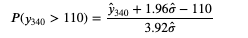

In [68]:
def probability(chance_value, spec, y_value=340):
    return (var(spec)[1][y_value] + 1.96 * var(spec)[0] - 110) / (3.92 * var(spec)[0])

In [69]:
probability(110, first_specification)

0.5078930193763729

In [70]:
probability(110, second_specification)

0.5122231617107946

In [71]:
probability(110, third_specification)

0.5165291132997576

In [72]:
probability(110, fourth_specification)

0.5369608080148183

### Question 3

In [22]:
first_specification_gdp = model('FrenchRetail.csv', quarters=True, last=True, GDP=True, h=1)
first_specification_gdp

Quarters dummy: True
Months dummy: False
Only Last: True
Parameters: (23.07364336328469, 0.1786025602394371, 10.067776633958458, 4.9796836114256426e-05)
Model Evals: (57.717270378308164, 19691.589199003083, 19710.7486113895)

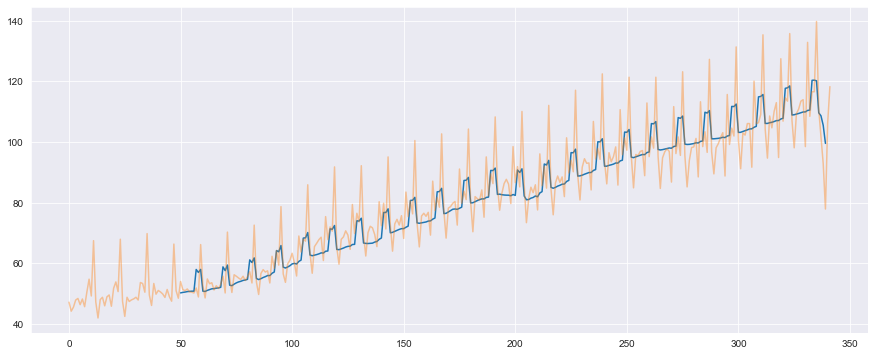

89.22412799515043

In [23]:
#MSFE for 1 step ahead (h=1). T0 = 50
plot_graph(first_specification_gdp.MSFE_1(T0=50, h=1, plot=True))
first_specification_gdp.MSFE_1(T0=50, h=1, plot=False)

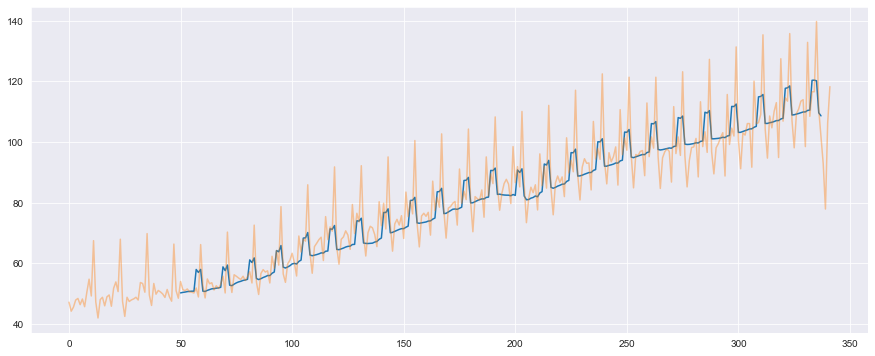

127.24313686306101

In [24]:
#MSFE for 3 step ahead (h=3). T0 = 50
plot_graph(first_specification_gdp.MSFE_1(T0=50, h=3, plot=True))
first_specification_gdp.MSFE_1(T0=50, h=3)

In [25]:
second_specification_gdp = model('FrenchRetail.csv', quarters=True, last=False, GDP=True, h=1)
second_specification_gdp

Quarters dummy: True
Months dummy: False
Only Last: False
Parameters: 0     0.177860
1    19.780459
2    23.617458
3    24.252050
4    32.605480
5     0.000051
dtype: float64
Model Evals: (54.77938022089527, 18689.768655325286, 18708.928067711702)

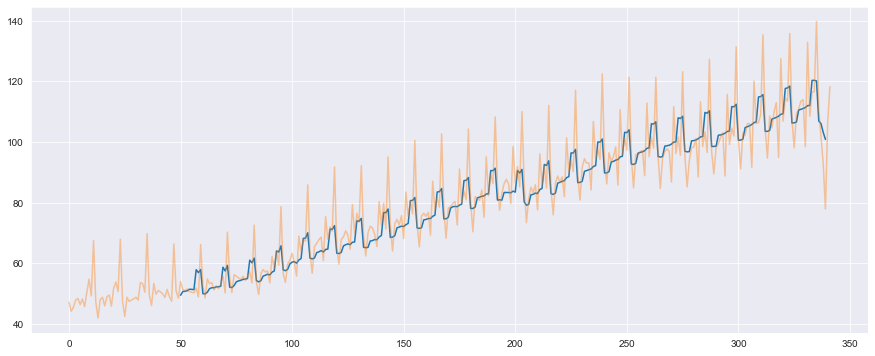

87.78737426317416

In [26]:
plot_graph(second_specification_gdp.MSFE_1(T0=50, h=1, plot=True))
second_specification_gdp.MSFE_1(T0=50, h=1)

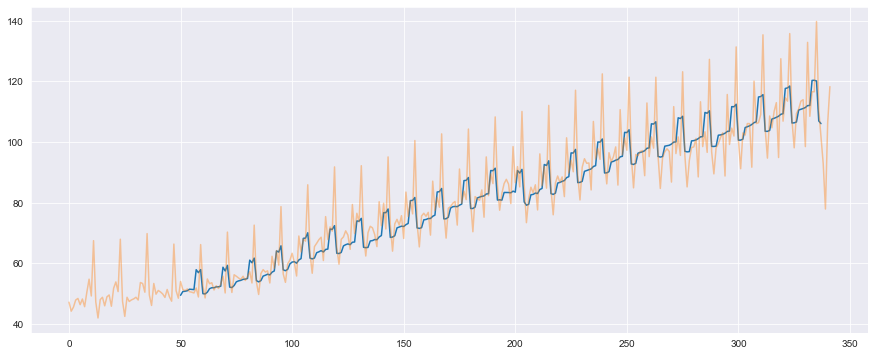

119.88932722196137

In [27]:
#MSFE for 3 step ahead (h=3). T0 = 50
plot_graph(second_specification_gdp.MSFE_1(T0=50, h=3, plot=True))
second_specification_gdp.MSFE_1(T0=50, h=3)

In [28]:
third_specification_gdp = model('FrenchRetail.csv', quarters=False, month=True, last=True, GDP=True, h=1)
third_specification_gdp

Quarters dummy: False
Months dummy: True
Only Last: True
Parameters: (22.428819551887855, 0.1765855551109462, 23.342487977279266, 5.311290986673354e-05)
Model Evals: (35.44661461249306, 12097.295582860133, 12116.454995246551)

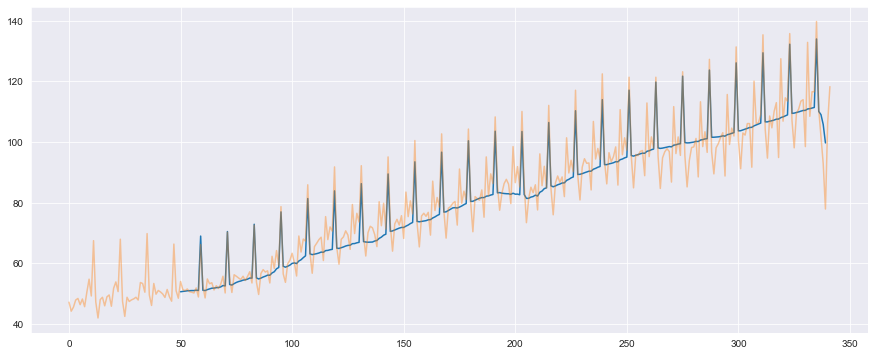

157.76259563883596

In [29]:
plot_graph(third_specification_gdp.MSFE_1(T0=50, h=1, plot=True))
third_specification_gdp.MSFE_1(T0=50, h=1)

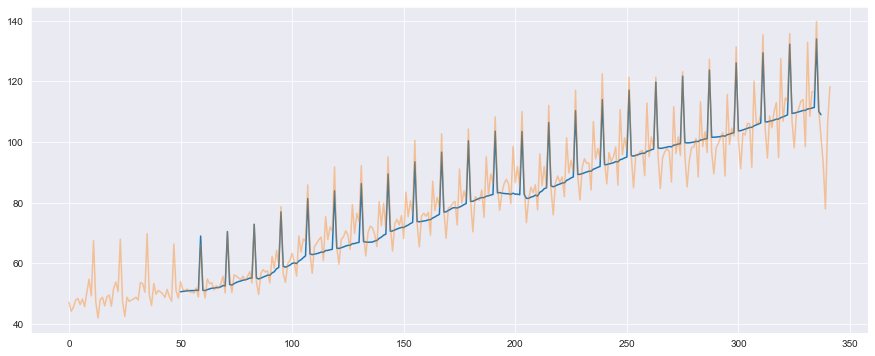

133.1920860964756

In [30]:
#MSFE for 3 step ahead (h=3). T0 = 50
plot_graph(third_specification_gdp.MSFE_1(T0=50, h=3, plot=True))
third_specification_gdp.MSFE_1(T0=50, h=3)

In [31]:
fourth_specification_gdp = model('FrenchRetail.csv', quarters=False, month=True, last=False, GDP=True, h=1)
fourth_specification_gdp

Quarters dummy: False
Months dummy: True
Only Last: False
Parameters: 0      0.175990
1     21.102448
2     13.894982
3     21.614380
4     21.473216
5     22.804978
6     23.800209
7     16.204570
8     31.247439
9     22.484579
10    26.636330
11    22.853223
12    45.510451
13     0.000054
dtype: float64
Model Evals: (17.829770093859228, 6089.951602005996, 6109.111014392414)

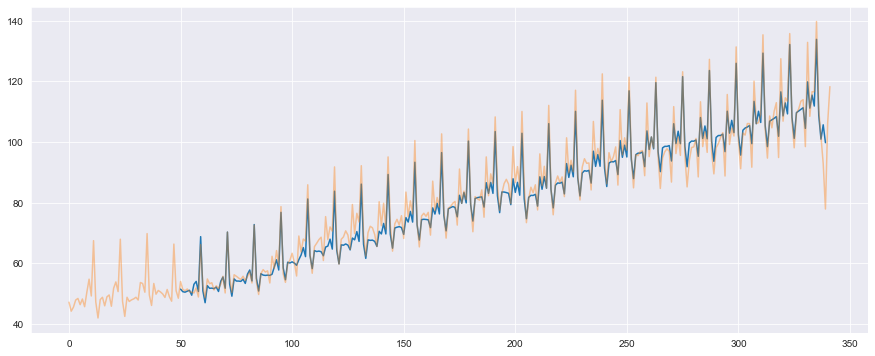

144.10266179568507

In [32]:
#h=1
plot_graph(fourth_specification_gdp.MSFE_1(T0=50, h=1, plot=True))
fourth_specification_gdp.MSFE_1(T0=50, h=1)

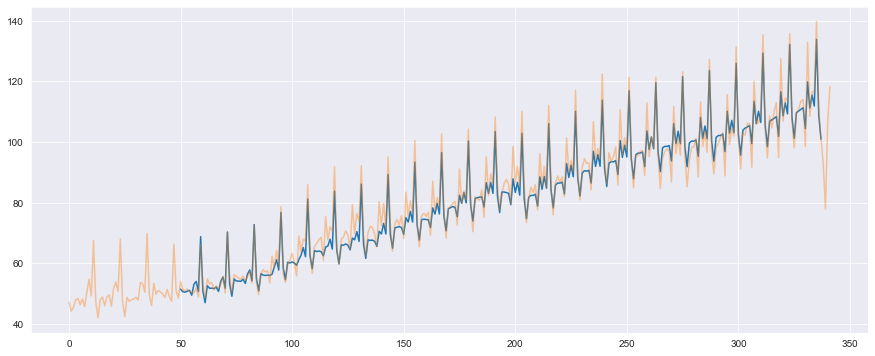

131.08407118911413

In [33]:
#MSFE for 3 step ahead (h=3). T0 = 50
plot_graph(fourth_specification_gdp.MSFE_1(T0=50, h=3, plot=True))
fourth_specification_gdp.MSFE_1(T0=50, h=3)

### Question 4

In [34]:
#Question 4 (part 1)
#Holt winters smoothing with seasonality to produce 1 step and 3 step ahead forecast. Compute MSFE for each. 
#alpha = beta = gamma = 0.4 (smoothing parameters). T0 = 50

In [35]:
#Simple exponential smoothing (SES) - no clear trend or seasonality
#Alpha is the rate at which the weights decrease (% of current value) Large alpha (close to 1) gives less weight to older values
#alpha = level, beta = trend, gamma = seeasonality. Parameters smooths each = 0.4. 
#m = frequency of the seasonality (4 or 12) in a year
#Seasonal = addititve? 

In [36]:
def HWS(T0, s, alpha, beta, gamma, h, T = len(y)):
    syhat = []
    S = np.zeros((1,T-h))[0]
    L = np.mean(y[1:s])
    b = 0
    S[1:s] = y[1:s] - L
    
    for t in range(s+1, T-h):
        newL = alpha * (y[t] - S[t-s]) + (1-alpha) * (L+b)
        newb = beta * (newL-L) + (1-beta)*b

        S[t] = gamma * (y[t] - newL) + (1-gamma)*S[t-s]
        yhat = newL + h*newb + S[t+h-s]
        L = newL
        b = newb
        if t >= T0:
            syhat.append(yhat)
    return syhat

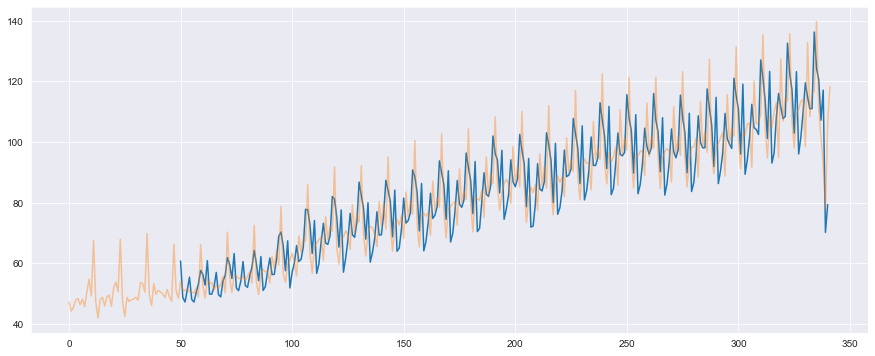

In [37]:
syhat = HWS(T0=50, s=4, alpha=0.4, beta=0.4, gamma=0.4, h=1)
plot_graph(syhat)

In [38]:
def MSFE(T0, h, y_pred):
    return np.mean((y[T0:-h]-syhat)**2)
MSFE(50, 1, syhat)

109.76155340529736

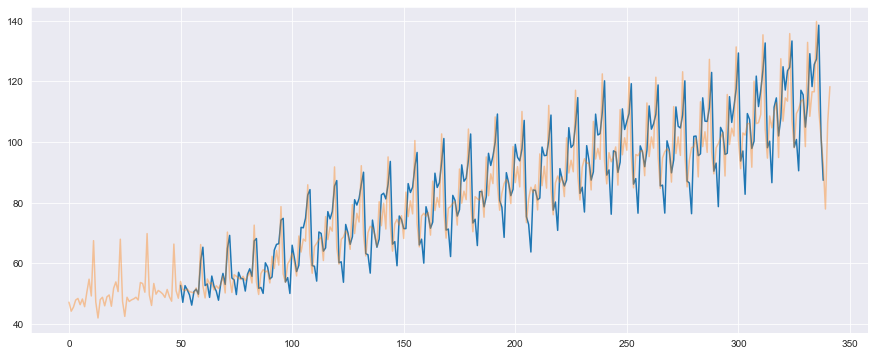

In [39]:
syhat = HWS(T0=50, s=4, alpha=0.4, beta=0.4, gamma=0.4, h=3)
plot_graph(syhat)

In [82]:
alpha = np.arange(0,1,0.1)
h = 1
beta = gamma = alpha
all_values = []
index = []
temp = []
for i in alpha:
    for j in beta:
        for k in gamma:
            syhat = HWS(50, 4, i, j, k, h)
            temp = MSFE(50, h, syhat)
            index.append((i,j,k))
            all_values.append(temp)
opt_point = np.array(index)[all_values == np.min(all_values)]
opt_point

array([[0.9, 0.2, 0. ]])

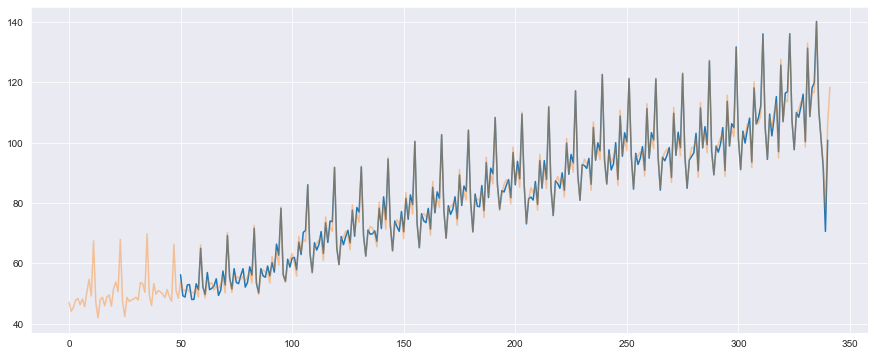

In [41]:
syhat = HWS(T0=50, s=4, alpha=0.9, beta=0.2, gamma=0, h=1)
plot_graph(syhat)

In [42]:
alpha = np.arange(0,1,0.1)
h = 3
beta = gamma = alpha
all_values = []
index = []
temp = []
for i in alpha:
    for j in beta:
        for k in gamma:
            syhat = HWS(50, 4, i, j, k, h)
            temp = MSFE(50, h, syhat)
            index.append((i,j,k))
            all_values.append(temp)
opt_point = np.array(index)[all_values == np.min(all_values)]
opt_point

array([[0.9, 0.1, 0. ]])

In [43]:
np.min(all_values)

6.124166823432225

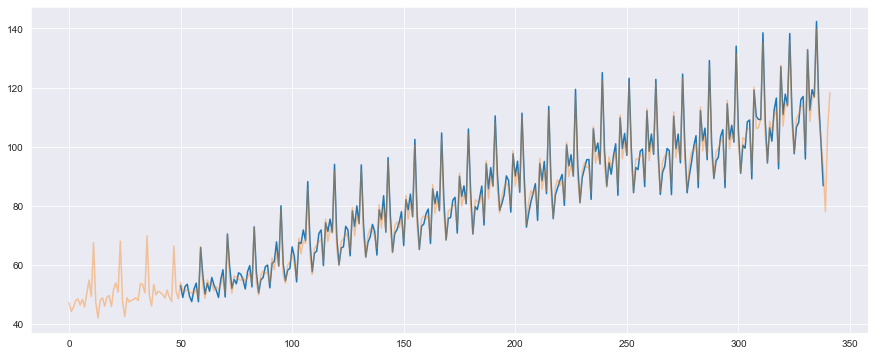

In [44]:
syhat = HWS(T0=50, s=4, alpha=0.9, beta=0.1, gamma=0, h=3)
plot_graph(syhat)

The optimizated parameters are in h=1: $\alpha$ = 0.9, $\beta$ = 0.2, $\gamma$ = 0
The optimizated parameters are in h=3: $\alpha$ = 0.9, $\beta$ = 0.1, $\gamma$ = 0
Compared with the baseline of 0.4 each. This indicates that recent level is important and past values of the trend and seasonality are more important, relative to the current

### Question 5

MSFE lowest in question 4 with chosen parameters

### Question 6

In [45]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.utils.plotting.forecasting import plot_ys

In [74]:
def MSFE_test(T0, y_pred):
    return np.mean(((y[T0:]-y_pred)**2))

0.027962655901546576

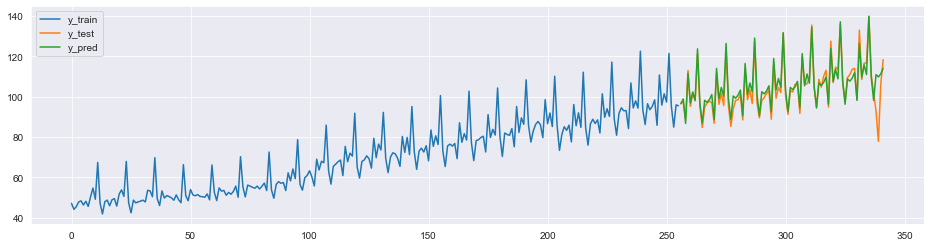

In [75]:
y_train, y_test = temporal_train_test_split(y)
fh = np.arange(1, len(y_test) + 1)  # forecasting horizon
forecaster = ExponentialSmoothing(trend="add", seasonal="mul", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [76]:
MSFE_test(256, y_pred)

23.293981275104525

In [49]:
forecaster.get_fitted_params()

{'initial_level': 68.29553063964195,
 'initial_slope': None,
 'initial_seasons': array([0.68780855, 0.63962616, 0.66902905, 0.69296226, 0.69553873,
        0.67890519, 0.70037038, 0.66287093, 0.73259776, 0.78865139,
        0.72014408, 0.97342351]),
 'smoothing_level': 0.19245862847173684,
 'smoothing_slope': None,
 'smoothing_seasonal': 0.7400459085944321,
 'damping_slope': None}

In [50]:
import sktime.forecasting as fc

In [51]:
from sktime.forecasting.arima import AutoARIMA as AA

### Question 7